## TFT Causal Discovery



In [1]:
%tensorboard --logdir logs #Clik above this to open tensorboard!

UsageError: Line magic function `%tensorboard` not found.


In [11]:
import tensorflow as tf
import datetime, os
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


Processing target variable: V1


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.18it/s, v_num=logs, train_loss=1.750]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.18it/s, v_num=logs, train_loss=1.750]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


<Figure size 1200x800 with 0 Axes>

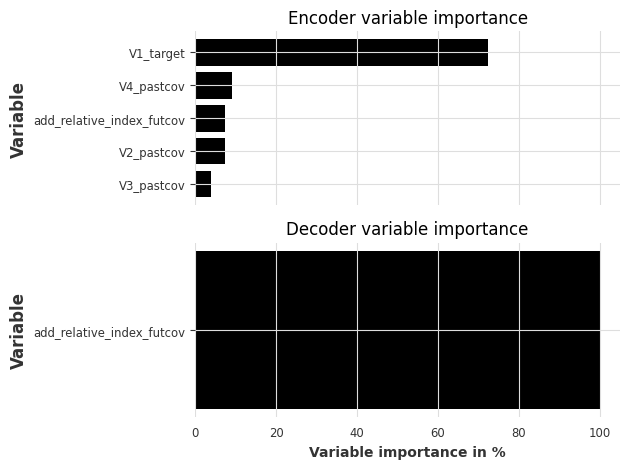

<Figure size 1200x800 with 0 Axes>

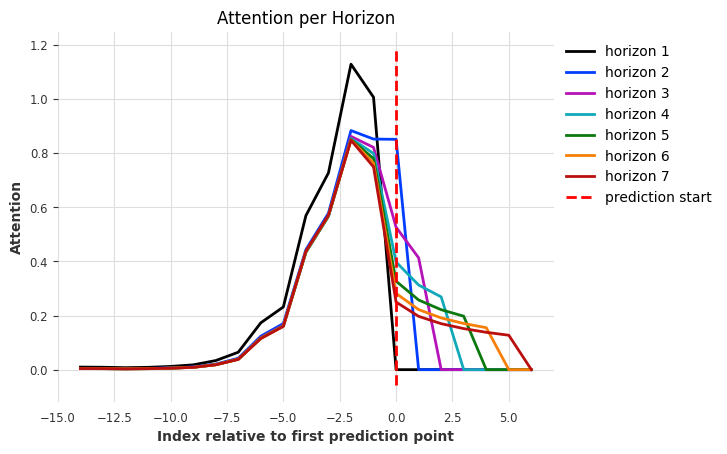

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:10<00:00,  0.09it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:10<00:00,  0.10it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V2: interval_score = 4.515168391391636, point_score = 1.2511361906146825
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/florisschouw/.pyenv/versions/3.10.14/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


TypeError: 'NoneType' object is not iterable

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from darts.explainability import TFTExplainer
from darts.dataprocessing.transformers import Scaler

def create_output_directory(dataset_name):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'./results_{dataset_name}_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def load_data(dataset_name):
    df = pd.read_csv(f'{dataset_name}.csv')
    df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')
    df.set_index('timestamp', inplace=True)
    df = df.drop('time_index', axis=1, errors='ignore')
    return df

def shuffle_covariate(covariates, column_name):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values()
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[:, column_index])
    shuffled_df = pd.DataFrame(
        values,
        columns=covariates.columns,
        index=covariates.time_index
    )
    return TimeSeries.from_dataframe(shuffled_df)

def point_estimate_score(y_true, y_pred):
    return mse(y_true, y_pred)

# def interval_score(y_true, y_pred_lower, y_pred_upper, alpha=0.2):
#     y_true_values = y_true.values()
#     lower_values = y_pred_lower.values()
#     upper_values = y_pred_upper.values()
    
#     coverage = np.mean((y_true_values >= lower_values) & (y_true_values <= upper_values))
#     width = np.mean(upper_values - lower_values)
#     return coverage - alpha * width

def interval_score(y_true, y_pred_lower, y_pred_upper, alpha=0.2):
    y_true_values = y_true.values()
    lower_values = y_pred_lower.values()
    upper_values = y_pred_upper.values()
    
    # Calculate the interval width
    interval_width = upper_values - lower_values
    
    # Calculate the penalties for observations outside the prediction interval
    under_predictions = np.maximum(0, lower_values - y_true_values)
    over_predictions = np.maximum(0, y_true_values - upper_values)
    
    # Calculate the interval score
    interval_score = np.mean(interval_width + 
                             2/alpha * under_predictions + 
                             2/alpha * over_predictions)
    
    return interval_score

def create_model(target_variable):
    return TFTModel(
        model_name=f"TFT_dataset0_80datasplit{target_variable}",
        input_chunk_length=14,
        output_chunk_length=7,
        hidden_size=64,
        lstm_layers=2,
        num_attention_heads=4,
        batch_size=32,
        n_epochs=2,
        add_relative_index=True,
        log_tensorboard=True,
    )

def save_model(model, output_dir, target_variable):
    model_dir = os.path.join(output_dir, 'saved_models')
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'{target_variable}_model.pth')
    model.save(model_path)
    print(f"Model saved to {model_path}")


def train_and_evaluate(target_variable, covariate_variables, df, num_samples, output_dir):
    target = TimeSeries.from_series(df[target_variable].astype(np.float32))
    covariates = TimeSeries.from_dataframe(df[covariate_variables].astype(np.float32))

    train_test_split = int(0.8 * len(target))
    train_target, test_target = target[:train_test_split], target[train_test_split:]
    train_covariates, test_covariates = covariates[:train_test_split], covariates[train_test_split:]

    model = create_model(target_variable)
    model.fit(train_target, past_covariates=train_covariates, verbose=True)

    # Save the trained model
    #save_model(model, output_dir, target_variable)
    
    # Generate and save explainability plots
    save_explainability_plots(model, output_dir, target_variable)

    predictions = model.predict(
        n=len(test_target),
        series=train_target,
        past_covariates=covariates,
        num_samples=num_samples
    )
    
    lower_pred = predictions.quantile_timeseries(0.1)
    median_pred = predictions.quantile_timeseries(0.5)
    upper_pred = predictions.quantile_timeseries(0.9)
    
    interval_score_value = interval_score(test_target, lower_pred, upper_pred)
    point_estimate_score_value = point_estimate_score(test_target, median_pred)
    
    # Generate and save prediction plots
    plot_and_save_predictions(test_target, predictions, point_estimate_score_value, output_dir, target_variable)
    
    return model, interval_score_value, point_estimate_score_value, train_target, test_target, covariates, train_test_split

def run_pfi_analysis(df, num_samples, output_dir):
    variables = df.columns.tolist()
    results = []

    for target_variable in variables:
        print(f"Processing target variable: {target_variable}")
        covariate_variables = [var for var in variables if var != target_variable]

        model, real_interval_score, real_point_score, train_target, test_target, covariates, train_test_split = train_and_evaluate(
            target_variable, covariate_variables, df, num_samples, output_dir
        )
        

        shuffle_interval_scores = {}
        shuffle_point_scores = {}
        for covariate in covariate_variables:
            shuffled_covariates = shuffle_covariate(covariates, covariate)
            shuffled_predictions = model.predict(
                n=len(test_target),
                series=train_target,
                past_covariates=shuffled_covariates,
                num_samples=num_samples
            )
            
            lower_pred = shuffled_predictions.quantile_timeseries(0.1)
            median_pred = shuffled_predictions.quantile_timeseries(0.5)
            upper_pred = shuffled_predictions.quantile_timeseries(0.9)
            
            shuffled_interval_score = interval_score(test_target, lower_pred, upper_pred)
            shuffled_point_score = point_estimate_score(test_target, median_pred)
            
            shuffle_interval_scores[covariate] = shuffled_interval_score
            shuffle_point_scores[covariate] = shuffled_point_score

            print(f"Shuffled {covariate}: interval_score = {shuffled_interval_score}, point_score = {shuffled_point_score}")

        results.append({
            'target': target_variable,
            'real_interval_score': real_interval_score,
            'real_point_score': real_point_score,
            'shuffle_interval_scores': shuffle_interval_scores,
            'shuffle_point_scores': shuffle_point_scores
        })

    return results


def save_results(results, output_dir, dataset_name):
    with open(os.path.join(output_dir, f'{dataset_name}_interval_scores.json'), 'w') as f:
        json.dump(results, f, indent=2)

def load_results(output_dir, dataset_name):
    with open(os.path.join(output_dir, f'{dataset_name}_interval_scores.json'), 'r') as f:
        return json.load(f)

def prepare_visualization_data(results):
    variables = [result['target'] for result in results]
    n_vars = len(variables)
    
    interval_scores_before = np.array([result['real_interval_score'] for result in results])
    point_scores_before = np.array([result['real_point_score'] for result in results])
    
    interval_scores_after = np.full((n_vars, n_vars), np.nan)
    point_scores_after = np.full((n_vars, n_vars), np.nan)

    for i, result in enumerate(results):
        for j, var in enumerate(variables):
            if var in result['shuffle_interval_scores']:
                interval_scores_after[i, j] = result['shuffle_interval_scores'][var]
                point_scores_after[i, j] = result['shuffle_point_scores'][var]

    interval_pfi_ratios = interval_scores_before[:, np.newaxis] / interval_scores_after
    point_pfi_ratios = point_scores_before[:, np.newaxis] / point_scores_after
    
    return variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios

def plot_and_save_predictions(test_target, predictions, point_estimate_score_value, output_dir, target_variable):
    plt.figure(figsize=(12, 6))
    test_target.plot(label="Actual")
    predictions.plot(label="Forecast")
    median_pred = predictions.quantile_timeseries(0.5)
    median_pred.plot(label="Forecast (quantile 0.5)")
    plt.title(f"TFT Forecast vs Actual for {target_variable}\nMSE: {point_estimate_score_value:.4f}")
    plt.legend()
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_predictions.png")
    plt.close()

def save_plot(fig, output_dir, filename):
    plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
    plt.close(fig)


def plot_interval_scores(variables, scores_before, scores_after, output_dir):

    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))

    label_positions = []

    for i, (var, score_before) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        ax.text(0.9, score_before, var, ha='right', va='center', fontweight='bold')
        
        for j, score_after in enumerate(scores_after[i]):
            if not np.isnan(score_after):
                ax.plot([1, 2], [score_before, score_after], '-', color=color)
                ax.scatter([1, 2], [score_before, score_after], color=color, s=100, zorder=5)
                label = f"{var} → {variables[j]}"
                label_positions.append((score_after, label))

    # Sort labels by y-position (score_after)
    label_positions.sort(key=lambda x: x[0], reverse=True)

    # Add labels with overlap adjustment
    label_height = 0.02  # Adjust this value to control label spacing
    last_y = float('inf')
    for score, label in label_positions:
        if score > last_y - label_height:
            score = last_y - label_height
        ax.text(2.05, score, label, ha='left', va='center')
        last_y = score

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'])
    ax.set_ylabel('Interval Score')
    ax.set_title('(a) Interval scores before and after permutation')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Adjust y-axis limits to add margin
    y_min, y_max = ax.get_ylim()
    y_margin = 0.1 * (y_max - y_min)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

    plt.tight_layout()
    save_plot(fig, output_dir, 'interval_scores.png')
    plt.close(fig)


def plot_point_scores(variables, scores_before, scores_after, output_dir):
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))

    label_positions = []

    for i, (var, score_before) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        ax.text(0.9, score_before, var, ha='right', va='center', fontweight='bold')
        
        for j, score_after in enumerate(scores_after[i]):
            if not np.isnan(score_after):
                ax.plot([1, 2], [score_before, score_after], '-', color=color)
                ax.scatter([1, 2], [score_before, score_after], color=color, s=100, zorder=5)
                label = f"{var} → {variables[j]}"
                label_positions.append((score_after, label))

    # Sort labels by y-position (score_after)
    label_positions.sort(key=lambda x: x[0], reverse=True)

    # Add labels with overlap adjustment
    label_height = 0.02  # Adjust this value to control label spacing
    last_y = float('inf')
    for score, label in label_positions:
        if score > last_y - label_height:
            score = last_y - label_height
        ax.text(2.05, score, label, ha='left', va='center')
        last_y = score

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'])
    ax.set_ylabel('Point Estimate Score (MSE)')
    ax.set_title('(Point estimate scores before and after permutation')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Adjust y-axis limits to add margin
    y_min, y_max = ax.get_ylim()
    y_margin = 0.1 * (y_max - y_min)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

    plt.tight_layout()
    save_plot(fig, output_dir, 'point_estimate_scores.png')
    plt.close(fig)

def plot_pfi_ratios(variables, pfi_ratios, score_type, output_dir):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(pfi_ratios, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, vmin=0, vmax=2,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(b) PFI ratio between variables ({score_type})', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    save_plot(fig, output_dir, f'pfi_ratios_{score_type.lower().replace(" ", "_")}.png')

def plot_adjacency_matrix(variables, pfi_ratios, score_type, output_dir, threshold=0.8):
    adjacency_matrix = (pfi_ratios < threshold).astype(int)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(adjacency_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(c) Final adjacency matrix based on {score_type} PFI', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    save_plot(fig, output_dir, f'adjacency_matrix_{score_type.lower().replace(" ", "_")}.png')

def save_explainability_plots(model, output_dir, target_variable):
    explainer = TFTExplainer(model)
    explainability_result = explainer.explain()
    
    # Variable selection plot
    plt.figure(figsize=(12, 8))
    explainer.plot_variable_selection(explainability_result)
    plt.title(f"Variable Selection for {target_variable}")
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_variable_selection.png")
    
    # Attention plot
    plt.figure(figsize=(12, 8))
    explainer.plot_attention(explainability_result)
    plt.title(f"Attention Plot for {target_variable}")
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_attention.png")

def save_all_plots_to_pdf(output_dir, dataset_name):
    pdf_path = os.path.join(output_dir, f'{dataset_name}_all_plots.pdf')
    with PdfPages(pdf_path) as pdf:
        for filename in os.listdir(output_dir):
            if filename.endswith('.png'):
                fig = plt.figure(figsize=(10, 8))
                img = plt.imread(os.path.join(output_dir, filename))
                plt.imshow(img)
                plt.axis('off')
                plt.title(filename.replace('.png', '').replace('_', ' '))
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)

def main(dataset_name, num_samples):
    output_dir = create_output_directory(dataset_name)
    df = load_data(dataset_name)
    results = run_pfi_analysis(df, num_samples, output_dir)
    save_results(results, output_dir, dataset_name)
    
    results = load_results(output_dir, dataset_name)
    variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios = prepare_visualization_data(results)
    
    plot_interval_scores(variables, interval_scores_before, interval_scores_after, output_dir)
    plot_point_scores(variables, point_scores_before, point_scores_after, output_dir)
    plot_pfi_ratios(variables, interval_pfi_ratios, "Interval Score", output_dir)
    plot_pfi_ratios(variables, point_pfi_ratios, "Point Estimate Score", output_dir)
    plot_adjacency_matrix(variables, interval_pfi_ratios, "Interval Score", output_dir)
    plot_adjacency_matrix(variables, point_pfi_ratios, "Point Estimate Score", output_dir)
    
    save_all_plots_to_pdf(output_dir, dataset_name)
    
    print(f"All results and plots saved in: {output_dir}")

if __name__ == "__main__":
    dataset_name = "synthetic_data_harvard_0"
    num_samples = 100
    main(dataset_name, num_samples)

In [44]:
def plot_point_scores(variables, scores_before, scores_after, output_dir):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Point Estimate Score (MSE)', fontsize=12)
    ax.set_title('(a) Point estimate scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    save_plot(fig, output_dir, 'point_estimate_scores.png')

In [8]:

def plot_point_scores(variables, scores_before, scores_after, output_dir):
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))

    label_positions = []

    for i, (var, score_before) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        ax.text(0.9, score_before, var, ha='right', va='center', fontweight='bold')
        
        for j, score_after in enumerate(scores_after[i]):
            if not np.isnan(score_after):
                ax.plot([1, 2], [score_before, score_after], '-', color=color)
                ax.scatter([1, 2], [score_before, score_after], color=color, s=100, zorder=5)
                label = f"{var} → {variables[j]}"
                label_positions.append((score_after, label))

    # Sort labels by y-position (score_after)
    label_positions.sort(key=lambda x: x[0], reverse=True)

    # Add labels with overlap adjustment
    label_height = 0.02  # Adjust this value to control label spacing
    last_y = float('inf')
    for score, label in label_positions:
        if score > last_y - label_height:
            score = last_y - label_height
        ax.text(2.05, score, label, ha='left', va='center')
        last_y = score

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'])
    ax.set_ylabel('Point Estimate Score (MSE)')
    ax.set_title('(Point estimate scores before and after permutation')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Adjust y-axis limits to add margin
    y_min, y_max = ax.get_ylim()
    y_margin = 0.1 * (y_max - y_min)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

    plt.tight_layout()
    save_plot(fig, output_dir, 'point_estimate_scores.png')
    plt.close(fig)

In [11]:
variables = ['V1', 'V2', 'V3', 'V4']
scores_before = [0.22, 0.48, 0.57, 0.65]
scores_after = [
    [0.23, 0.21, np.nan, np.nan],  # V1 permutations
    [0.42, 0.48, np.nan, np.nan],  # V2 permutations
    [0.30, 0.55, 0.57, np.nan],    # V3 permutations
    [0.64, 0.65, np.nan, np.nan]   # V4 permutations
]
output_dir = './results'

plot_point_scores(variables, scores_before, scores_after, output_dir)

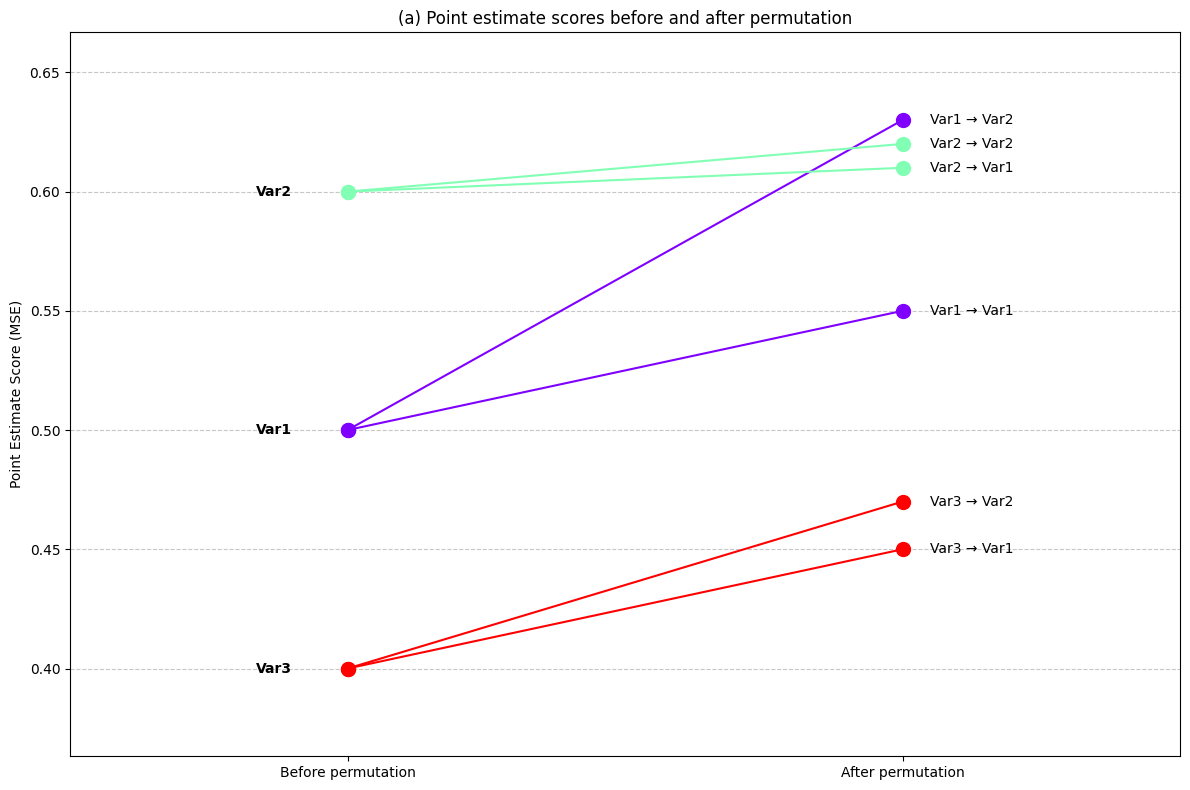

<Figure size 640x480 with 0 Axes>

In [4]:
import os

# Sample data
variables = ['Var1', 'Var2', 'Var3']
scores_before = [0.5, 0.6, 0.4]
scores_after = [[0.55, 0.63], [0.61, 0.62], [0.45, 0.47]]
output_dir = 'plots'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Call the function
plot_point_scores(variables, scores_before, scores_after, output_dir)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 18.2 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 7.0 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Processing target variable: Boerenkaas
Epoch 7:  50%|█████     | 2/4 [00:00<00:00,  5.73it/s, v_num=logs, train_loss=10.30]

/Users/florisschouw/.pyenv/versions/3.10.14/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.77it/s]


<Figure size 1200x800 with 0 Axes>

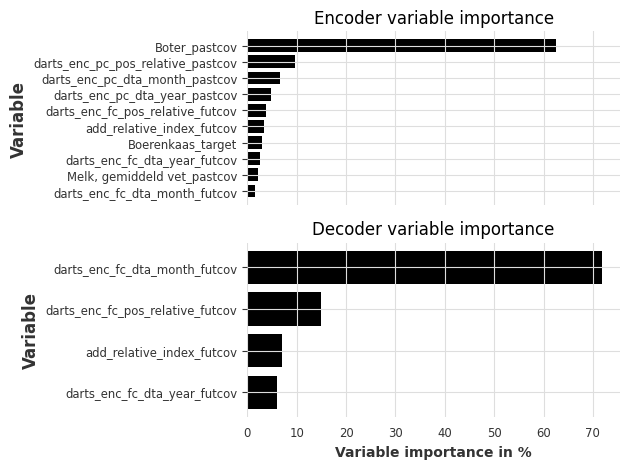

<Figure size 1200x800 with 0 Axes>

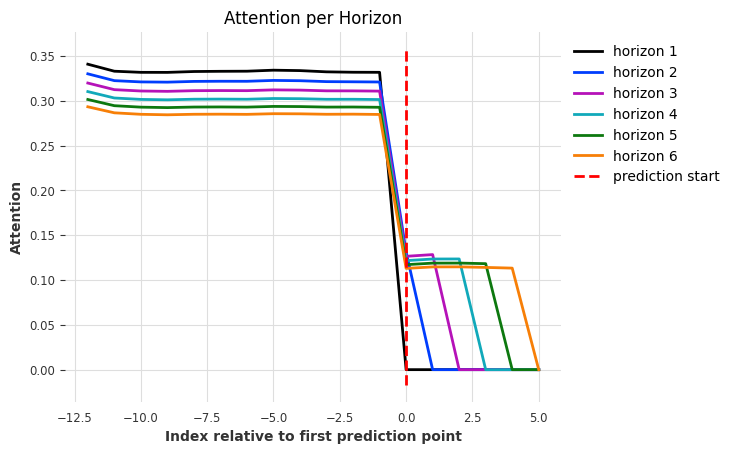

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  0.32it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.44it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled Boter: interval_score = -0.33651759139869525, point_score = 6.572519943546571
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 18.2 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 7.0 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled Melk, gemiddeld vet: interval_score = -0.3324419896239821, point_score = 6.501177583740479
Processing target variable: Boter
Epoch 399: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, v_num=logs, train_loss=0.270]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s, v_num=logs, train_loss=0.270]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


<Figure size 1200x800 with 0 Axes>

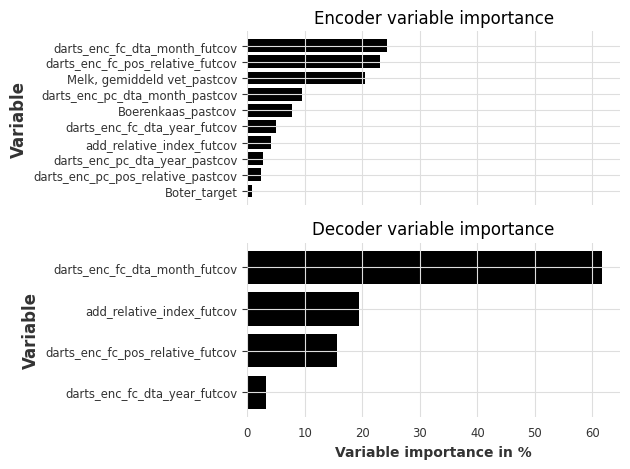

<Figure size 1200x800 with 0 Axes>

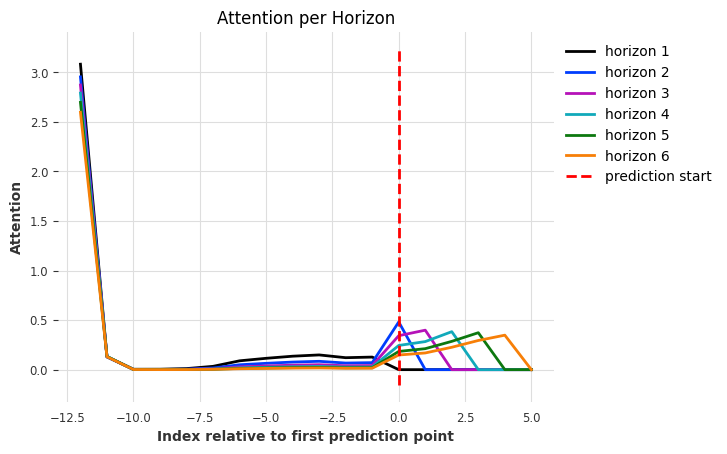

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.45it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.45it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled Boerenkaas: interval_score = 0.01699504137039183, point_score = 1.1286463517445426
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.45it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 18.2 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 7.0 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled Melk, gemiddeld vet: interval_score = -0.022907113873440306, point_score = 1.1362968680559475
Processing target variable: Melk, gemiddeld vet


/Users/florisschouw/.pyenv/versions/3.10.14/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 399: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, v_num=logs, train_loss=0.266]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, v_num=logs, train_loss=0.266]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.16it/s]


<Figure size 1200x800 with 0 Axes>

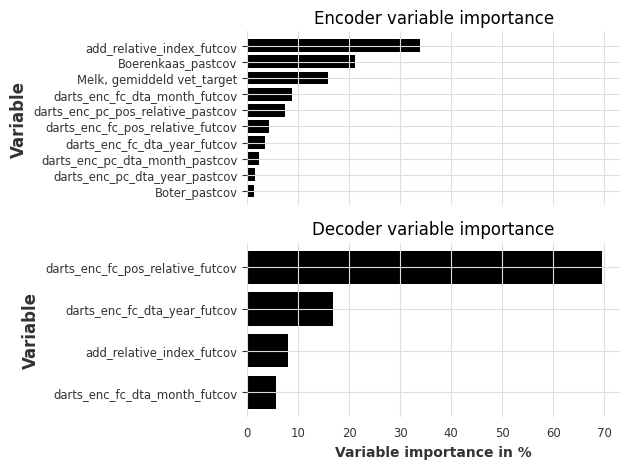

<Figure size 1200x800 with 0 Axes>

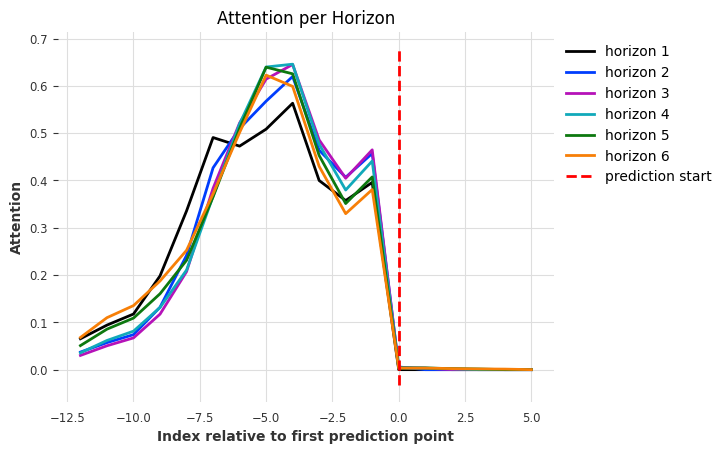

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled Boerenkaas: interval_score = 0.17398700848869653, point_score = 0.2594978014549333
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.44it/s]
Shuffled Boter: interval_score = 0.1286856981464054, point_score = 0.31063053911678695
All results and plots saved in: ./results_output_melk_reversed_20241002_224342


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from darts.explainability import TFTExplainer
from darts.dataprocessing.transformers import Scaler

def create_output_directory(dataset_name):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'./results_{dataset_name}_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def load_data(dataset_name):
    df = pd.read_csv(f'{dataset_name}.csv')
    df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')
    df.set_index('timestamp', inplace=True)
    df = df.drop('time_index', axis=1, errors='ignore')
    return df

def shuffle_covariate(covariates, column_name):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values()
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[:, column_index])
    shuffled_df = pd.DataFrame(
        values,
        columns=covariates.columns,
        index=covariates.time_index
    )
    return TimeSeries.from_dataframe(shuffled_df)

def point_estimate_score(y_true, y_pred):
    return mse(y_true, y_pred)

def interval_score(y_true, y_pred_lower, y_pred_upper, alpha=0.2):
    y_true_values = y_true.values()
    lower_values = y_pred_lower.values()
    upper_values = y_pred_upper.values()
    
    coverage = np.mean((y_true_values >= lower_values) & (y_true_values <= upper_values))
    width = np.mean(upper_values - lower_values)
    return coverage - alpha * width

def create_model(target_variable):
    return TFTModel(
        model_name= f"ENCODES_TFT_dataset_milk_{target_variable}",
        input_chunk_length=12,
        output_chunk_length=6,
        hidden_size=64,
        lstm_layers=2,
        num_attention_heads=4,
        batch_size=32,
        n_epochs=400,
        add_relative_index=True,
        log_tensorboard=True,
        add_encoders={
            'datetime_attribute': {
                'past': ['month', 'year'],
                'future': ['month', 'year']
            },
            'position': {
                'past': ['relative'],
                'future': ['relative']
            },
            'transformer': Scaler()
        }
    )

def save_model(model, output_dir, target_variable):
    model_dir = os.path.join(output_dir, 'saved_models')
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'{target_variable}_model.pth')
    model.save(model_path)
    print(f"Model saved to {model_path}")


def train_and_evaluate(target_variable, covariate_variables, df, num_samples, output_dir):
    target = TimeSeries.from_series(df[target_variable].astype(np.float32))
    covariates = TimeSeries.from_dataframe(df[covariate_variables].astype(np.float32))

    train_test_split = int(0.6 * len(target))
    train_target, test_target = target[:train_test_split], target[train_test_split:]
    train_covariates, test_covariates = covariates[:train_test_split], covariates[train_test_split:]

    model = create_model(target_variable)


    
    model.fit(train_target, past_covariates=train_covariates, verbose=True)
    # Save the trained model
    #save_model(model, output_dir, target_variable)
    
    # Generate and save explainability plots
    save_explainability_plots(model, output_dir, target_variable)

    predictions = model.predict(
        n=len(test_target),
        series=train_target,
        past_covariates=covariates,
        num_samples=num_samples
    )
    
    lower_pred = predictions.quantile_timeseries(0.1)
    median_pred = predictions.quantile_timeseries(0.5)
    upper_pred = predictions.quantile_timeseries(0.9)
    
    interval_score_value = interval_score(test_target, lower_pred, upper_pred)
    point_estimate_score_value = point_estimate_score(test_target, median_pred)
    
    # Generate and save prediction plots
    plot_and_save_predictions(test_target, predictions, point_estimate_score_value, output_dir, target_variable)
    
    return model, interval_score_value, point_estimate_score_value, train_target, test_target, covariates, train_test_split

def run_pfi_analysis(df, num_samples, output_dir):
    variables = df.columns.tolist()
    results = []

    for target_variable in variables:
        print(f"Processing target variable: {target_variable}")
        covariate_variables = [var for var in variables if var != target_variable]

        model, real_interval_score, real_point_score, train_target, test_target, covariates, train_test_split = train_and_evaluate(
            target_variable, covariate_variables, df, num_samples, output_dir
        )
        

        shuffle_interval_scores = {}
        shuffle_point_scores = {}
        for covariate in covariate_variables:
            shuffled_covariates = shuffle_covariate(covariates, covariate)
            shuffled_predictions = model.predict(
                n=len(test_target),
                series=train_target,
                past_covariates=shuffled_covariates,
                num_samples=num_samples
            )
            
            lower_pred = shuffled_predictions.quantile_timeseries(0.1)
            median_pred = shuffled_predictions.quantile_timeseries(0.5)
            upper_pred = shuffled_predictions.quantile_timeseries(0.9)
            
            shuffled_interval_score = interval_score(test_target, lower_pred, upper_pred)
            shuffled_point_score = point_estimate_score(test_target, median_pred)
            
            shuffle_interval_scores[covariate] = shuffled_interval_score
            shuffle_point_scores[covariate] = shuffled_point_score

            print(f"Shuffled {covariate}: interval_score = {shuffled_interval_score}, point_score = {shuffled_point_score}")

        results.append({
            'target': target_variable,
            'real_interval_score': real_interval_score,
            'real_point_score': real_point_score,
            'shuffle_interval_scores': shuffle_interval_scores,
            'shuffle_point_scores': shuffle_point_scores
        })

    return results


def save_results(results, output_dir, dataset_name):
    with open(os.path.join(output_dir, f'{dataset_name}_interval_scores.json'), 'w') as f:
        json.dump(results, f, indent=2)

def load_results(output_dir, dataset_name):
    with open(os.path.join(output_dir, f'{dataset_name}_interval_scores.json'), 'r') as f:
        return json.load(f)

def prepare_visualization_data(results):
    variables = [result['target'] for result in results]
    n_vars = len(variables)
    
    interval_scores_before = np.array([result['real_interval_score'] for result in results])
    point_scores_before = np.array([result['real_point_score'] for result in results])
    
    interval_scores_after = np.full((n_vars, n_vars), np.nan)
    point_scores_after = np.full((n_vars, n_vars), np.nan)

    for i, result in enumerate(results):
        for j, var in enumerate(variables):
            if var in result['shuffle_interval_scores']:
                interval_scores_after[i, j] = result['shuffle_interval_scores'][var]
                point_scores_after[i, j] = result['shuffle_point_scores'][var]

    interval_pfi_ratios = interval_scores_before[:, np.newaxis] / interval_scores_after
    point_pfi_ratios = point_scores_before[:, np.newaxis] / point_scores_after
    
    return variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios

def plot_and_save_predictions(test_target, predictions, point_estimate_score_value, output_dir, target_variable):
    plt.figure(figsize=(12, 6))
    test_target.plot(label="Actual")
    predictions.plot(label="Forecast")
    median_pred = predictions.quantile_timeseries(0.5)
    median_pred.plot(label="Forecast (quantile 0.5)")
    plt.title(f"TFT Forecast vs Actual for {target_variable}\nMSE: {point_estimate_score_value:.4f}")
    plt.legend()
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_predictions.png")
    plt.close()

def save_plot(fig, output_dir, filename):
    plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
    plt.close(fig)


def plot_interval_scores(variables, scores_before, scores_after, output_dir):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Interval Score', fontsize=12)
    ax.set_title('(a) Interval scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    save_plot(fig, output_dir, 'interval_scores.png')

def plot_point_scores(variables, scores_before, scores_after, output_dir):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Point Estimate Score (MSE)', fontsize=12)
    ax.set_title('(a) Point estimate scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    save_plot(fig, output_dir, 'point_estimate_scores.png')

def plot_pfi_ratios(variables, pfi_ratios, score_type, output_dir):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(pfi_ratios, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, vmin=0, vmax=2,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(b) PFI ratio between variables ({score_type})', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    save_plot(fig, output_dir, f'pfi_ratios_{score_type.lower().replace(" ", "_")}.png')

def plot_adjacency_matrix(variables, pfi_ratios, score_type, output_dir, threshold=0.8):
    adjacency_matrix = (pfi_ratios < threshold).astype(int)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(adjacency_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(c) Final adjacency matrix based on {score_type} PFI', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    save_plot(fig, output_dir, f'adjacency_matrix_{score_type.lower().replace(" ", "_")}.png')

def save_explainability_plots(model, output_dir, target_variable):
    explainer = TFTExplainer(model)
    explainability_result = explainer.explain()
    
    # Variable selection plot
    plt.figure(figsize=(12, 8))
    explainer.plot_variable_selection(explainability_result)
    plt.title(f"Variable Selection for {target_variable}")
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_variable_selection.png")
    
    # Attention plot
    plt.figure(figsize=(12, 8))
    explainer.plot_attention(explainability_result)
    plt.title(f"Attention Plot for {target_variable}")
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_attention.png")

def save_all_plots_to_pdf(output_dir, dataset_name):
    pdf_path = os.path.join(output_dir, f'{dataset_name}_all_plots.pdf')
    with PdfPages(pdf_path) as pdf:
        for filename in os.listdir(output_dir):
            if filename.endswith('.png'):
                fig = plt.figure(figsize=(10, 8))
                img = plt.imread(os.path.join(output_dir, filename))
                plt.imshow(img)
                plt.axis('off')
                plt.title(filename.replace('.png', '').replace('_', ' '))
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)

def main(dataset_name, num_samples):
    output_dir = create_output_directory(dataset_name)
    df = load_data(dataset_name)
    results = run_pfi_analysis(df, num_samples, output_dir)
    save_results(results, output_dir, dataset_name)
    
    results = load_results(output_dir, dataset_name)
    variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios = prepare_visualization_data(results)
    
    plot_interval_scores(variables, interval_scores_before, interval_scores_after, output_dir)
    plot_point_scores(variables, point_scores_before, point_scores_after, output_dir)
    plot_pfi_ratios(variables, interval_pfi_ratios, "Interval Score", output_dir)
    plot_pfi_ratios(variables, point_pfi_ratios, "Point Estimate Score", output_dir)
    plot_adjacency_matrix(variables, interval_pfi_ratios, "Interval Score", output_dir)
    plot_adjacency_matrix(variables, point_pfi_ratios, "Point Estimate Score", output_dir)
    
    save_all_plots_to_pdf(output_dir, dataset_name)
    
    print(f"All results and plots saved in: {output_dir}")

if __name__ == "__main__":
    dataset_name = "output_melk_reversed"
    num_samples = 100
    main(dataset_name, num_samples)